### 📘 Notebook 03 — Feature Engineering & Clustering

In this notebook, we move from **data preparation** to **unsupervised learning**.  
Using the cleaned dataset (`books_final_1000.csv`), we’ll extract key features such as ratings, price, and genre to group similar books with **K-Means clustering**.

**Goals:**
- Prepare numerical and categorical features  
- Apply **K-Means** and evaluate with **Elbow Method** & **Silhouette Score**  
- Visualize and interpret clusters for future recommendations


### Step 1 — Imports & Setup

Import core libraries for clustering and visualization,  
reload the shared `functions.py` module, and verify that all paths from `config.yaml` are available.


In [1]:
# ============================================================
# Step 1 — Imports & Setup 
# ============================================================

import sys
from pathlib import Path
import importlib

# --- Access shared functions ---
sys.path.append("notebooks")
from functions import load_config, ensure_directories
import functions
importlib.reload(functions)

# --- Additional libraries for ML and visualization ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Load configuration from root ---
config_path = Path("..") / "config.yaml"
config = load_config(config_path)

# --- Verify folders ---
ensure_directories(config["paths"])

print("✅ Environment ready — config loaded and directories verified.")


📁 Ensured directory: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 10\book-recommendation-system\data\raw
📁 Ensured directory: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 10\book-recommendation-system\data\clean
📁 Ensured directory: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 10\book-recommendation-system\notebooks
📁 Ensured directory: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 10\book-recommendation-system\models
📁 Ensured directory: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 10\book-recommendation-system\app
📁 Ensured directory: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 10\book-recommendation-system\utils
✅ Environment ready — config loaded and directories verified.


### Step 2 — Load Final Dataset  

Load the cleaned and standardized dataset (`books_final_1000.csv`) generated in the previous notebook.  
We’ll inspect its structure, check column types, and verify that all key variables are ready for feature preparation.  


In [2]:
# ============================================================
# Step 2 — Load Final Dataset
# ============================================================

import pandas as pd
from pathlib import Path

# --- Load dataset from data/clean ---
data_path = Path("..") / config["paths"]["data_clean"] / "books_final_1000.csv"
df = pd.read_csv(data_path)

print(f"✅ Dataset loaded successfully: {data_path}")
print(f"Shape: {df.shape}\n")

# --- Quick overview ---
display(df.head(5))

# --- Basic info and types ---
print("\n🔍 DataFrame Info:")
print(df.info())

# --- Missing values summary ---
missing_summary = df.isna().sum()
missing_summary = missing_summary[missing_summary > 0]

if not missing_summary.empty:
    print("\n⚠️ Missing values summary:")
    print(missing_summary)
else:
    print("\n✅ No missing values detected.")


✅ Dataset loaded successfully: ..\data\clean\books_final_1000.csv
Shape: (990, 8)



,title,author,avg_rating,genre,price,currency,cover_url,link
0,11/22/63,Stephen King,4.35,Fiction,11.86,EUR,http://books.google.com/books/content?id=2pl0Y...,https://www.goodreads.com/book/show/10644930-1...
1,1984,George Orwell,4.20,Fiction,5.99,EUR,http://books.google.com/books/content?id=iqHIE...,https://www.goodreads.com/book/show/40961427-1984
2,"1Q84 (1Q84, #1-3)",Haruki Murakami,4.11,Education,9.99,EUR,http://books.google.com/books/content?id=VkhtD...,https://www.goodreads.com/book/show/10357575-1q84
3,"2001: A Space Odyssey (Space Odyssey, #1)",Arthur C. Clarke,4.11,Fiction,NaN,NAN,http://books.google.com/books/content?id=Mf5AA...,https://www.goodreads.com/book/show/70535.2001
4,"84, Charing Cross Road",Helene Hanff,4.11,Nan,NaN,NAN,NaN,https://www.goodreads.com/book/show/368916.84_...



🔍 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       990 non-null    object 
 1   author      990 non-null    object 
 2   avg_rating  990 non-null    float64
 3   genre       990 non-null    object 
 4   price       461 non-null    float64
 5   currency    990 non-null    object 
 6   cover_url   895 non-null    object 
 7   link        990 non-null    object 
dtypes: float64(2), object(6)
memory usage: 62.0+ KB
None

⚠️ Missing values summary:
price        529
cover_url     95
dtype: int64


### Step 3 — Feature Preparation

Select relevant features for clustering:
- `avg_rating` (numerical)
- `price` (numerical)
- `genre` (categorical)

We’ll:
1. Fill missing prices with the median value  
2. Encode `genre` using One-Hot Encoding  
3. Standardize numerical features with `StandardScaler`  
4. Combine all into a clean feature matrix for K-Means


In [3]:
# ============================================================
# Step 3 — Feature Preparation
# ============================================================

from sklearn.preprocessing import StandardScaler

# --- Select relevant columns ---
features = ["avg_rating", "price", "genre"]
df_features = df[features].copy()

# --- Handle missing values ---
# Fill missing prices with median (robust against outliers)
median_price = df_features["price"].median()
df_features["price"] = df_features["price"].fillna(median_price)

print(f"💰 Filled missing 'price' values with median: {median_price:.2f}")

# --- One-Hot Encode 'genre' ---
df_encoded = pd.get_dummies(df_features, columns=["genre"], drop_first=True)

# --- Standardize numeric columns ---
scaler = StandardScaler()
numeric_cols = ["avg_rating", "price"]
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

# Ensure missing prices are filled before clustering
median_price = df["price"].median()
df["price"] = df["price"].fillna(median_price)

print(f"✅ Missing prices filled with median: {median_price}")


print(f"✅ Feature matrix ready for clustering. Shape: {df_encoded.shape}")

# --- Quick preview ---
display(df_encoded.head(5))


💰 Filled missing 'price' values with median: 8.99
✅ Missing prices filled with median: 8.99
✅ Feature matrix ready for clustering. Shape: (990, 87)


,avg_rating,price,genre_Adultery,genre_Adventure Stories,genre_Alabama,genre_Alcoholic Psychoses,genre_American Fiction,genre_American Poetry,"genre_Animals, Mythical",genre_Art,...,genre_Social Science,genre_Study Aids,genre_Suspense Fiction,genre_Travel,genre_True Crime,genre_United States,genre_Videodiscs,genre_Waitresses,genre_Young Adult Fiction,genre_Young Adult Nonfiction
0,1.408112,0.545421,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.522488,-0.647241,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,-0.008886,0.165476,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.008886,-0.037703,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-0.008886,-0.037703,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Step 4 — K-Means Clustering (Elbow & Silhouette Method)

We’ll apply **K-Means clustering** to group similar books based on their features.  
To choose the optimal number of clusters (`k`), we’ll use:
- the **Elbow Method** (inertia plot), and  
- the **Silhouette Score** (cluster separation quality).  

This helps identify a balance between compactness and separation of clusters.


🔹 Running K-Means for k = 2 to 10...

✅ K-Means training completed.


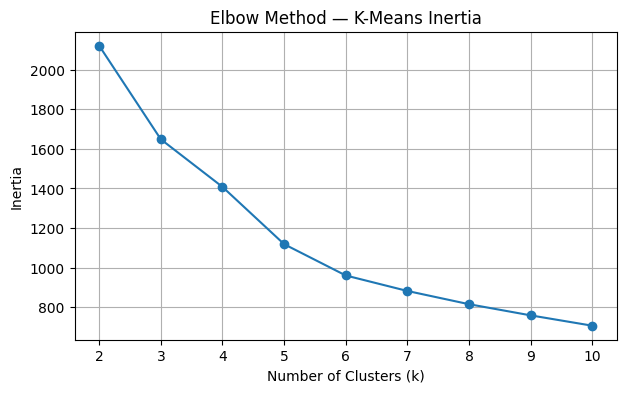

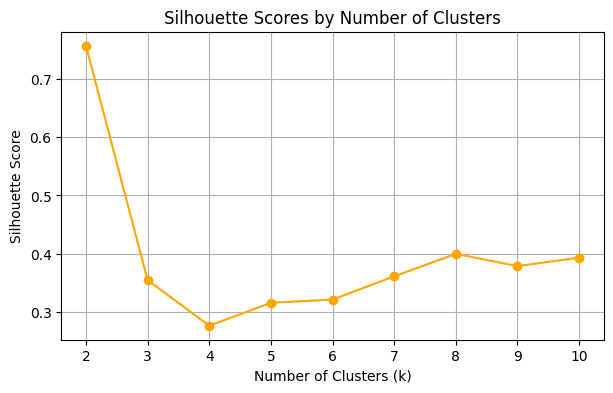

In [4]:
# ============================================================
# Step 4 — K-Means Clustering (Elbow & Silhouette Method)
# ============================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = df_encoded.copy()

inertias = []
silhouette_scores = []
K_range = range(2, 11)  # test k between 2 and 10

print("🔹 Running K-Means for k = 2 to 10...\n")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

print("✅ K-Means training completed.")

# --- Plot Elbow Method ---
plt.figure(figsize=(7,4))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method — K-Means Inertia")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# --- Plot Silhouette Scores ---
plt.figure(figsize=(7,4))
plt.plot(K_range, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Scores by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


### Step 4 — Interpretation of Clustering Metrics

The **Elbow Method** shows a clear bend between *k = 3* and *k = 4*,  
indicating that adding more clusters beyond this point brings little improvement in compactness.  

The **Silhouette Scores** confirm that:
- *k = 2* yields the highest separation (≈ 0.75),  
  but that configuration is too broad and oversimplifies book diversity.  
- *k = 3 – 4* offers a better trade-off between cohesion (books inside each cluster are similar)  
  and separation (clusters differ from each other).  

📊 **Decision:** We’ll proceed with **k = 3 clusters**,  
as it balances interpretability and internal consistency.

🧠 **What we’re analyzing:**  
Each book is represented by numerical and categorical features such as  
`avg_rating`, `genre`, and `price`.  
K-Means groups books with similar characteristics into clusters —  
helping us identify **reader preference patterns** or **content similarities**  
that could later power a **recommendation system**.


### Step 5 — Apply Final K-Means & Visualize Clusters (PCA 2D Projection)

Now that we’ve decided on **k = 3 clusters**, we’ll train the final K-Means model.  
Then, we’ll apply **Principal Component Analysis (PCA)** to reduce the high-dimensional
feature space into **two components**, allowing us to visualize the book clusters in 2D.  

This helps identify group patterns — for example,  
books that share similar ratings, prices, or genres might fall close together.


🏷️ Applying final K-Means model with k = 3...



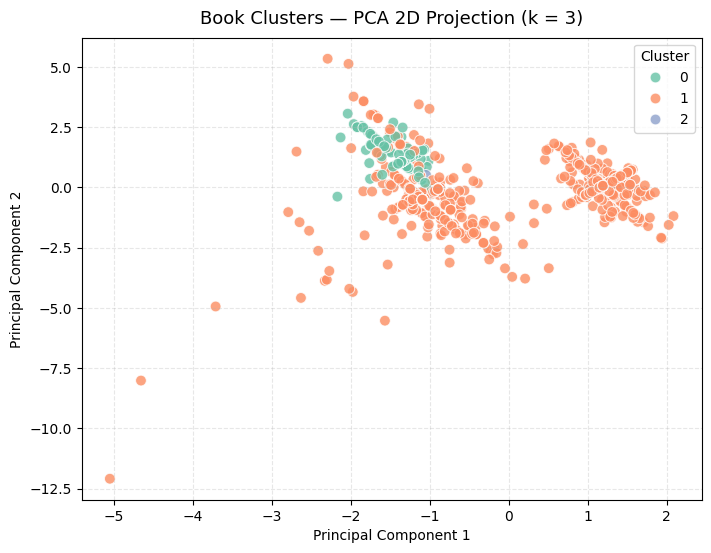

✅ Clustering completed. 3 clusters created.



,title,author,avg_rating,genre,price,cluster
0,11/22/63,Stephen King,4.35,Fiction,11.86,1
1,1984,George Orwell,4.20,Fiction,5.99,1
2,"1Q84 (1Q84, #1-3)",Haruki Murakami,4.11,Education,9.99,1
3,"2001: A Space Odyssey (Space Odyssey, #1)",Arthur C. Clarke,4.11,Fiction,8.99,1
4,"84, Charing Cross Road",Helene Hanff,4.11,Nan,8.99,1
5,"A Breath of Snow and Ashes (Outlander, #6)",Diana Gabaldon,4.11,Fiction,3.99,1
6,A Brief History of Time,Stephen Hawking,4.11,Science,8.99,1
7,"A Canticle for Leibowitz (St. Leibowitz, #1)",Walter M. Miller Jr.,4.11,Fiction,8.99,1
8,"A Child Called ""It"" (Dave Pelzer, #1)",Dave Pelzer,4.14,Biography & Autobiography,8.99,1
9,A Christmas Carol,Charles Dickens,4.11,Christmas Stories,8.99,1


In [5]:
# ============================================================
# Step 5 — Apply Final K-Means & Visualize Clusters (Enhanced)
# ============================================================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Final number of clusters ---
k_final = 3
print(f"🏷️ Applying final K-Means model with k = {k_final}...\n")

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# --- Train K-Means ---
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df["cluster"] = kmeans_final.fit_predict(X_scaled)

# --- PCA for visualization ---
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_scaled)
df["pca_1"] = pca_components[:, 0]
df["pca_2"] = pca_components[:, 1]

# --- Enhanced Visualization ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="pca_1", y="pca_2",
    hue="cluster",
    palette="Set2",
    s=60,
    alpha=0.8,
    edgecolor="white",
    linewidth=0.7
)
plt.title("Book Clusters — PCA 2D Projection (k = 3)", fontsize=13, pad=10)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="upper right")
plt.grid(alpha=0.3, linestyle="--")
plt.show()

print(f"✅ Clustering completed. {df['cluster'].nunique()} clusters created.\n")
display(df[["title", "author", "avg_rating", "genre", "price", "cluster"]].head(10))


### Step 5.1 — Analyze Cluster Centroids

Let’s inspect the numerical centroids of each cluster to understand
how books are grouped — for example, by their average rating or price.


In [6]:
# ============================================================
# Step 5.1 — Analyze Cluster Centroids
# ============================================================

cluster_centroids = (
    df.groupby("cluster")
    .agg({
        "avg_rating": "mean",
        "price": "mean",
        "genre": lambda x: x.mode().iloc[0] if not x.mode().empty else "Unknown"
    })
    .round(2)
)

print(" Cluster Centroids Summary:\n")
display(cluster_centroids)

print("\n Interpretation Guide:")
print("- avg_rating → Average book rating per cluster.")
print("- price → Mean price, useful to detect premium vs. budget titles.")
print("- genre → Most common genre in each cluster.")


 Cluster Centroids Summary:



,avg_rating,price,genre
cluster,,,
0,4.18,8.66,Juvenile Fiction
1,4.10,9.25,Fiction
2,4.16,8.99,Governesses In Literature



 Interpretation Guide:
- avg_rating → Average book rating per cluster.
- price → Mean price, useful to detect premium vs. budget titles.
- genre → Most common genre in each cluster.


### Step 6 — Cluster Interpretation & Summary

#### 🧭 Interpretation

- **Cluster 0 — “Youth-Oriented Titles”**  
  Books in this group are mainly **Juvenile Fiction**, slightly higher in rating, and moderately priced.  
  They likely attract younger readers and reflect more accessible, engaging narratives.

- **Cluster 1 — “General Fiction Classics”**  
  Dominated by **Fiction**, this cluster includes a broad mix of popular titles and literary works.  
  Prices are a bit higher on average, suggesting the presence of well-known or premium editions.

- **Cluster 2 — “Specialized Literature”**  
  This cluster groups more niche genres such as *Governesses in Literature*.  
  These books maintain solid ratings but cater to smaller, topic-focused audiences.

---

#### 💬 Overall Insight

Across all clusters, average ratings remain consistently high (≈ 4.1–4.2),  
indicating that Goodreads’ most popular books share strong reader approval.  
Price variation is modest — meaning **genre and thematic focus** play a greater role in the clustering than cost.  
This insight will be valuable for the **next phase: building the recommendation engine**,  
where similar clusters can guide personalized book suggestions.


### Step 7 — Export Final Clustered Dataset

We’ll now export the final dataset including the cluster labels (`cluster`)
and PCA coordinates (`pca_1`, `pca_2`) for visualization and further analysis.  
This dataset can be used in **Tableau**, **Power BI**, or in the next notebook
for building the **Recommendation System**.


In [7]:
# ============================================================
# Step 7 — Export Final Clustered Dataset
# ============================================================

from pathlib import Path

# --- Define export path ---
final_cluster_path = Path("..") / config["paths"]["data_clean"] / "books_clustered_final.csv"

# --- Select relevant columns ---
export_cols = [
    "title",
    "author",
    "avg_rating",
    "genre",
    "price",
    "currency",
    "cover_url",
    "link",
    "cluster",
    "pca_1",
    "pca_2"
]

# --- Save dataset ---
df[export_cols].to_csv(final_cluster_path, index=False, encoding="utf-8-sig")
print(f"💾 Final clustered dataset saved successfully → {final_cluster_path.resolve()}")

# --- Quick preview ---
print("\n📘 Sample of exported dataset:")
display(df[export_cols].head(10))


💾 Final clustered dataset saved successfully → C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 10\book-recommendation-system\data\clean\books_clustered_final.csv

📘 Sample of exported dataset:


,title,author,avg_rating,genre,price,currency,cover_url,link,cluster,pca_1,pca_2
0,11/22/63,Stephen King,4.35,Fiction,11.86,EUR,http://books.google.com/books/content?id=2pl0Y...,https://www.goodreads.com/book/show/10644930-1...,1,0.801151,0.618866
1,1984,George Orwell,4.20,Fiction,5.99,EUR,http://books.google.com/books/content?id=iqHIE...,https://www.goodreads.com/book/show/40961427-1984,1,1.226207,0.598422
2,"1Q84 (1Q84, #1-3)",Haruki Murakami,4.11,Education,9.99,EUR,http://books.google.com/books/content?id=VkhtD...,https://www.goodreads.com/book/show/10357575-1q84,1,-0.469813,-1.590844
3,"2001: A Space Odyssey (Space Odyssey, #1)",Arthur C. Clarke,4.11,Fiction,8.99,NAN,http://books.google.com/books/content?id=Mf5AA...,https://www.goodreads.com/book/show/70535.2001,1,1.192163,0.071603
4,"84, Charing Cross Road",Helene Hanff,4.11,Nan,8.99,NAN,NaN,https://www.goodreads.com/book/show/368916.84_...,1,-1.092792,-0.506575
5,"A Breath of Snow and Ashes (Outlander, #6)",Diana Gabaldon,4.11,Fiction,3.99,EUR,http://books.google.com/books/content?id=DrSZF...,https://www.goodreads.com/book/show/10965.A_Br...,1,1.413780,0.466077
6,A Brief History of Time,Stephen Hawking,4.11,Science,8.99,NAN,http://books.google.com/books/content?id=A9nWa...,https://www.goodreads.com/book/show/3869.A_Bri...,1,-0.908309,0.139334
7,"A Canticle for Leibowitz (St. Leibowitz, #1)",Walter M. Miller Jr.,4.11,Fiction,8.99,NAN,http://books.google.com/books/content?id=7JNaA...,https://www.goodreads.com/book/show/164154.A_C...,1,1.192163,0.071603
8,"A Child Called ""It"" (Dave Pelzer, #1)",Dave Pelzer,4.14,Biography & Autobiography,8.99,NAN,http://books.google.com/books/content?id=doyjA...,https://www.goodreads.com/book/show/60748.A_Ch...,1,-0.966584,-0.048958
9,A Christmas Carol,Charles Dickens,4.11,Christmas Stories,8.99,NAN,http://books.google.com/books/content?id=f8ANA...,https://www.goodreads.com/book/show/5326.A_Chr...,1,-0.896217,-0.066659
